# Import

In [1]:
import pandas as pd
import plotly.graph_objs as go
import string
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import cufflinks as cf
from plotly.offline import iplot
from tqdm import tqdm

from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
import plotly.express as px

import plotly.io as pio
pio.renderers.default='notebook'

import warnings
warnings.simplefilter('ignore')

from rectools import Columns
from rectools.dataset import Dataset

from lightfm import LightFM
from lightfm.data import Dataset
import scipy.sparse as sp
from lightfm.evaluation import precision_at_k

import os

In [ ]:
# функция для расчета map@k

def mapk(model, df_test, df_train, k, item_features = None):
    test_precision = precision_at_k(model=model, 
                            test_interactions=df_test,
                            k=k,
                            item_features = item_features,
                            train_interactions=df_train)
    map_at_k = test_precision.mean()
    return map_at_k

In [3]:
us = os.getcwd()
print(us)

if 'liliyaivannikova' in us:
    PATH = r'/Users/liliyaivannikova/Documents/project/ml-latest/'
    movies = pd.read_csv(PATH + r'movies.csv')
    rating = pd.read_csv(PATH + r'ratings.csv')
elif 'Владислав' in us:
    movies = pd.read_csv(r'dataset/movies.csv')
    rating = pd.read_csv(r'dataset/ratings.csv')
    
print(f'''
movies: {movies.shape}
rating: {rating.shape}
''')

In [5]:
movies.columns = [col.upper() for col in movies.columns]
movies['REALEASE'] = movies['TITLE'].str.extract("\((\d{4})\)", expand=True)
movies['REALEASE'] = pd.to_datetime(movies['REALEASE'], format='%Y')
movies['REALEASE'] = movies['REALEASE'].dt.year
movies['TITLE'] = movies['TITLE'].str[:-7]

# dummy-кодирование жанров
dfx = movies['GENRES'].str.get_dummies(sep='|')
for col in dfx.columns:
    dfx[col] = dfx[col].astype('int8')
    
movies = pd.concat([movies, dfx], axis=1) #.drop(columns=['GENRES'])
movies['TITLE'] = movies['TITLE'].astype('category')
movies['REALEASE'] = movies['REALEASE'].astype('float16')
movies['GENRES'] = movies['GENRES'].str.replace('|', ',')

rating.columns = [col.upper() for col in rating.columns]
rating['TIMESTAMP'] = pd.to_datetime(rating['TIMESTAMP'], unit='s')

# Фильтрация строк

In [205]:
# считаем кол-во оценок в рамках userid
rating_stat = rating.groupby('USERID')['MOVIEID'].count().reset_index()
rating_stat['MOVIEID'].quantile(0.4)

21.0

In [12]:
#rating_stat['FLAG_05'] = np.where(rating_stat['MOVIEID'] > rating_stat['MOVIEID'].quantile(0.05), 1, 0)
'''при текущих симуляцих мы отфильтровали наш набор данных, оставив для построения только userid, которые
оценили больше 20 фильмов
'''
rating_stat['FLAG_05'] = np.where(rating_stat['MOVIEID'] > rating_stat['MOVIEID'].quantile(0.4), 1, 0)
rating = rating.merge(rating_stat[['USERID', 'FLAG_05']], how = 'left', on = 'USERID')
rating.head()

,USERID,MOVIEID,RATING,TIMESTAMP,FLAG_05
0,1,1,4.0,2008-11-03 17:52:19,1
1,1,110,4.0,2008-11-05 06:04:46,1
2,1,158,4.0,2008-11-03 17:31:43,1
3,1,260,4.5,2008-11-03 18:00:04,1
4,1,356,5.0,2008-11-03 17:58:39,1


In [13]:
'''
По результатам EDA
'''
# удаляем пропуски
rating = rating[~((rating.TIMESTAMP.isna())|(rating.USERID.isna())|(rating.RATING.isna()))]
# удаляем странного юзера 
rating.query('USERID != 189614', inplace = True)
# удалим юзеров, у которых оценок меньше 3 (по 5 квантилю)
rating.query('FLAG_05 == 1', inplace = True)
print(rating.shape)

(32346391, 5)


# train-test-split

In [14]:
rating.rename({'USERID':'user_id',
            'MOVIEID':'item_id',
            'RATING':'weight',
            'TIMESTAMP':'datetime'}, axis=1, inplace=True)

movies.rename({'MOVIEID':'item_id'}, axis=1, inplace=True)

In [17]:
'''
бьем на train/test по времени (20 последних оценок идут в test)
'''
rating.sort_values(['user_id', 'datetime'], inplace=True)

train_ratings, test_ratings = [], []
num_test_samples = 10

for userId, user_data in rating.groupby('user_id'):
    train_ratings += [user_data[:-num_test_samples]]
    test_ratings += [user_data[-num_test_samples:]]

train_ratings = pd.concat(train_ratings)
test_ratings = pd.concat(test_ratings)
train_ratings.shape, test_ratings.shape

((30357121, 5), (1989270, 5))

In [18]:
del rating

# LightFM

In [28]:
# формирование спарс матриц
dataset = Dataset()
dataset.fit(train_ratings['user_id'].unique(), train_ratings['item_id'].unique(), 
            item_features=movies['GENRES'].values)

dataset.fit_partial(users=test_ratings['user_id'], items=test_ratings['item_id'],
                   item_features=movies['GENRES'].values)

train_mat, _ = dataset.build_interactions(train_ratings.loc[:, ['user_id', 'item_id']].values.tolist())
test_mat, _ = dataset.build_interactions(test_ratings.loc[:, ['user_id', 'item_id']].values.tolist())

train_movies = movies.loc[movies['item_id'].isin(train_ratings['item_id']), ['item_id', 'GENRES']]
features = [[v[0], v[1:].values.tolist()] for i, v in train_movies.loc[:, ['item_id', 'GENRES']].iterrows()]
movies_features = dataset.build_item_features(features)

## Обучение модели без доп фичей

In [38]:
NO_COMPONENTS = 64
LOSS = 'warp'
RANDOM_STATE = 42
EPOCHS = 5
LEARNING_RATE = 0.01

In [42]:
%%time
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    loss = LOSS,
    learning_rate = LEARNING_RATE,
    random_state = RANDOM_STATE
    )

lfm_model.fit_partial(
        train_mat, 
        epochs=EPOCHS,
        num_threads = 4)

mapk(model = lfm_model, df_test = test_mat, df_train = train_mat, k = 10)*100

3.1327573000974844

## Обучение модели с доп фичами (добавили жанры)

In [51]:
%%time
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    loss = LOSS,
    learning_rate = LEARNING_RATE,
    random_state = RANDOM_STATE
    )

lfm_model.fit_partial(
        train_mat, 
        epochs=EPOCHS,
        item_features = movies_features,
        num_threads = 4
    )

mapk(model = lfm_model, df_test = test_mat, df_train = train_mat, k = 10,
        item_features = movies_features)*100

6.105707213282585

# Подбор гиперапараметров

In [175]:
'''
Тут симуляция. Так как на всем наборе данных это считается несколько дней.
Берем user_id, у которых более 200 оценок
'''

items_s = (train_ratings['item_id'].value_counts() > 15000)
users_s = (train_ratings['user_id'].value_counts() > 1000)

items_s = items_s[items_s].index.tolist()
users_s = users_s[users_s].index.tolist()

train_s = train_ratings.loc[(train_ratings['item_id'].isin(items_s)) & 
                            (train_ratings['user_id'].isin(users_s))]
# отбираем случайные наблюдения на тесте по выбранным выше userid
test_s = test_ratings.loc[(test_ratings['item_id'].isin(items_s)) & 
                            (test_ratings['user_id'].isin(users_s))]
'''
Формирование спарс матриц на подмножестве
'''
dataset_s = Dataset()
dataset_s.fit(train_s['user_id'].unique(), train_s['item_id'].unique(), 
                item_features=movies['GENRES'].values)

dataset_s.fit_partial(users=test_s['user_id'], items=test_s['item_id'],
                       item_features=movies['GENRES'].values)

train_mat_s, _ = dataset.build_interactions(train_s.loc[:, ['user_id', 'item_id']].values.tolist())
test_mat_s, _ = dataset.build_interactions(test_s.loc[:, ['user_id', 'item_id']].values.tolist())

train_movies_s = movies.loc[movies['item_id'].isin(train_s['item_id']), ['item_id', 'GENRES']]
features_s = [[v[0], v[1:].values.tolist()] for i, v in train_movies_s.loc[:, ['item_id', 'GENRES']].iterrows()]
movies_features_s = dataset.build_item_features(features_s)


In [176]:
%%time

'''
Изучим влияние loss ф-ии
'''
epochs = 100 # количество эпох

# алгоритм на warp
warp_model = LightFM(no_components=NO_COMPONENTS,
                    loss='warp',
                    learning_rate = LEARNING_RATE,
                    random_state = RANDOM_STATE)

# алгоритм на bpr
bpr_model = LightFM(no_components=NO_COMPONENTS,
                    loss='bpr',
                    learning_rate = LEARNING_RATE,
                    random_state = RANDOM_STATE)


warp_mapk = []
bpr_mapk = []

for epoch in tqdm(range(0, epochs, 2)):
    
    '''
    Обучение моделей с помощью warp/bpr
    '''
    warp_model.fit_partial(train_mat_s, epochs=1, 
                              item_features = movies_features_s,
                              num_threads = 4)
    warp_mapk.append(precision_at_k(model=warp_model, 
                            test_interactions=test_mat_s,
                            k=3,
                            item_features = movies_features_s,
                            train_interactions=train_mat_s).mean())
    
    bpr_model.fit_partial(train_mat_s, epochs=1, 
                              item_features = movies_features,
                              num_threads = 4)
    bpr_mapk.append(precision_at_k(model=bpr_model, 
                            test_interactions=test_mat_s,
                            k=3,
                            item_features = movies_features_s,
                            train_interactions=train_mat_s).mean())

100%|██████████| 50/50 [1:11:33<00:00, 85.86s/it]

CPU times: user 1h 11min 17s, sys: 1.76 s, total: 1h 11min 18s
Wall time: 1h 11min 33s


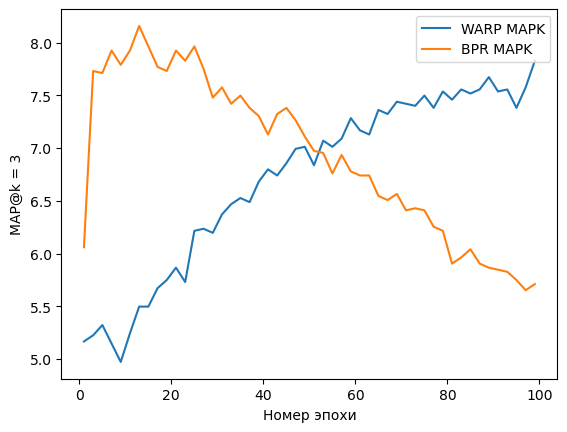

In [191]:
x = np.arange(1, epochs, 2)
plt.plot(x, np.array(warp_mapk)*100)
plt.plot(x, np.array(bpr_mapk)*100)
plt.xlabel('Номер эпохи')
plt.ylabel('MAP@k = 3')
plt.legend(['WARP MAPK', 'BPR MAPK'], loc='upper right')
plt.savefig('lightfm_loss.png')
plt.show()

In [178]:
%%time

'''
Изучим влияние loss ф-ии
'''
epochs = 100 # количество эпох

# алгоритм на warp
grad_model = LightFM(no_components=NO_COMPONENTS,
                    loss='warp',
                    learning_rate = LEARNING_RATE,
                    learning_schedule='adagrad',
                    random_state = RANDOM_STATE)

# алгоритм на bpr
delta_model = LightFM(no_components=NO_COMPONENTS,
                    loss='warp',
                    learning_rate = LEARNING_RATE,
                    learning_schedule='adadelta',
                    random_state = RANDOM_STATE)


grad_mapk = []
delta_mapk = []

for epoch in tqdm(range(0, epochs, 2)):
    
    '''
    Обучение моделей с помощью warp/bpr
    '''
    grad_model.fit_partial(train_mat_s, epochs=1, 
                              item_features = movies_features_s,
                              num_threads = 4)
    grad_mapk.append(precision_at_k(model=grad_model, 
                            test_interactions=test_mat_s,
                            k=3,
                            item_features = movies_features_s,
                            train_interactions=train_mat_s).mean())
    
    delta_model.fit_partial(train_mat_s, epochs=1, 
                              item_features = movies_features,
                              num_threads = 4)
    delta_mapk.append(precision_at_k(model=delta_model, 
                            test_interactions=test_mat_s,
                            k=3,
                            item_features = movies_features_s,
                            train_interactions=train_mat_s).mean())

100%|██████████| 50/50 [1:25:33<00:00, 102.66s/it]  

CPU times: user 10min 26s, sys: 611 ms, total: 10min 27s
Wall time: 1h 25min 33s


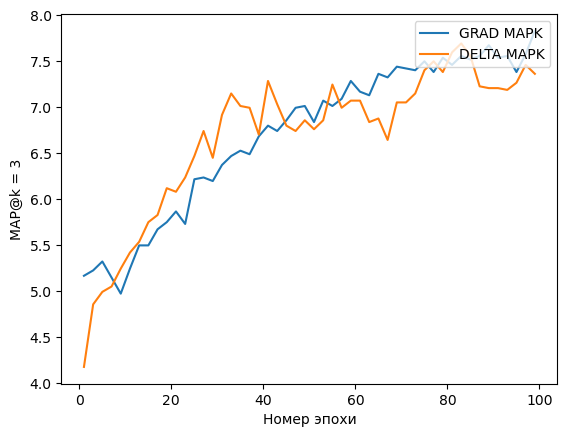

In [192]:
x = np.arange(1, epochs, 2)
plt.plot(x, np.array(grad_mapk)*100)
plt.plot(x, np.array(delta_mapk)*100)
plt.xlabel('Номер эпохи')
plt.ylabel('MAP@k = 3')
plt.legend(['GRAD MAPK', 'DELTA MAPK'], loc='upper right')
plt.savefig('lightfm_grad.png')
plt.show()

# Финальная модель лучшего качества

In [184]:
%%time
model = LightFM(no_components=NO_COMPONENTS,
                    loss='warp',
                    learning_rate = LEARNING_RATE,
                    learning_schedule='adagrad',
                    random_state = RANDOM_STATE)

# Обучение
model.fit(train_mat, 
              epochs=100, 
              item_features = movies_features,
              num_threads = 4)

In [186]:
import pickle

pickle.dump(model, open('lfm_model_fin_v2.pkl', 'wb'))

In [187]:
mapk_list_k = list()
K = np.arange(2, 20, 2)

for k in tqdm(K):
    
    mapk_list_k.append(mapk(model = model, df_test = test_mat, df_train = train_mat,
                              k = k, item_features = movies_features))
    
mapk_comp_arr = np.array(mapk_list_k)*100

100%|██████████| 9/9 [1:54:46<00:00, 765.13s/it]


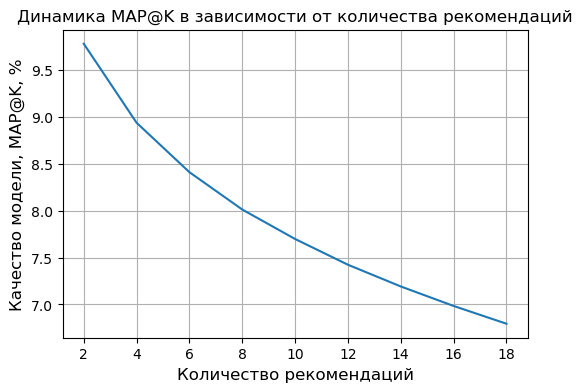

In [189]:
fig = plt.figure(figsize=(6,4))

plt.plot(K, mapk_comp_arr, markersize=8)

plt.xlabel('Количество рекомендаций', fontsize=12)
plt.ylabel('Качество модели, MAP@K, %', fontsize=12)
plt.title('Динамика MAP@K в зависимости от количества рекомендаций', fontsize=12)
plt.grid(True)
plt.savefig('lightfm_k.png')
plt.show()

In [190]:
mapk(model = model, df_test = test_mat, 
     df_train = train_mat, k = 10, item_features = movies_features)*100

7.697848975658417